In [1]:
!pip install transformers pyarabic regex coral-pytorch camel-tools torch_geometric
!pip install -U datasets huggingface_hub

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["WANDB_DISABLED"] = "true"

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import json
from functools import partial
import pyarabic.araby as araby
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch_geometric.data import Data

2025-07-21 19:34:37.758203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753126477.781134    1328 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753126477.788508    1328 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset

In [ ]:

# Load sentence-level data from the "Dev" split
dataset = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-sent", split="train")
eval_dataset = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-sent", split="validation")
test_dataset = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-sent", split="test")

# Load sentence-level data from the "official_blind" split
# Set token to access the blind test dataset
# read token from environment variable
token = os.getenv("HUGGINGFACE_TOKEN", None)
if token is None:
    raise ValueError("Please set the HUGGINGFACE_TOKEN environment variable.")
blind_test_dataset = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-BlindTest-sent", token=token, split="test")

# Fix labels to be 0-indexed
dataset = dataset.map(lambda x: {"labels": x["Readability_Level_19"] - 1, "Sentence": araby.strip_diacritics(x["Sentence"])})
eval_dataset = eval_dataset.map(lambda x: {"labels": x["Readability_Level_19"] - 1, "Sentence": araby.strip_diacritics(x["Sentence"])})
test_dataset = test_dataset.map(lambda x: {"labels": x["Readability_Level_19"] - 1, "Sentence": araby.strip_diacritics(x["Sentence"])})
blind_test_dataset = blind_test_dataset.map(lambda x: {"Sentence": araby.strip_diacritics(x["Sentence"])})

df = pd.DataFrame(dataset)
df.head(100)

,ID,Sentence,Word_Count,Readability_Level,Readability_Level_19,Readability_Level_7,Readability_Level_5,Readability_Level_3,Annotator,Document,Source,Book,Author,Domain,Text_Class,labels
0,10100290001,مجلة كل الأولاد وكل البنات,5,7-zay,7,2,1,1,A2,BAREC_Majed_0413_1987_001.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,6
1,10100290002,ماجد,1,1-alif,1,1,1,1,A2,BAREC_Majed_0413_1987_001.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,0
2,10100290003,الأربعاء 21 يناير 1987,4,8-Ha,8,3,2,1,A3,BAREC_Majed_0413_1987_001.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,7
3,10100290004,الموافق 21 جمادى الأول 1407هــ,6,7-zay,7,2,1,1,A3,BAREC_Majed_0413_1987_001.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,6
4,10100290005,السنة الثامنة,2,5-ha,5,2,1,1,A4,BAREC_Majed_0413_1987_001.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10100300074,أحمد بالقاسم خليفة,3,3-jim,3,1,1,1,A2,BAREC_Majed_0413_1987_002.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,2
96,10100300075,المدينة المنورة – السعودية,4,11-kaf,11,4,2,1,A1,BAREC_Majed_0413_1987_002.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,10
97,10100300076,الحصان العربي.. قوي.. رشيق.. جميل.. سريع.,15,7-zay,7,2,1,1,A4,BAREC_Majed_0413_1987_002.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,6
98,10100300077,الدينار,1,11-kaf,11,4,2,1,A1,BAREC_Majed_0413_1987_002.txt,Majed,Edition: 413,#,Arts & Humanities,Foundational,10


In [6]:
import re
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.charmap import CharMapper

arclean = CharMapper.builtin_mapper("arclean")

def clean_broken_arabic_words(text):
    """ Clean broken Arabic words and remove tatweel characters."""
    
    def clean_line(line, arclean):
        return simple_word_tokenize(arclean(dediac_ar(normalize_unicode(line.strip()))))
    
    # Step 1: Remove broken words like الشــــــمس <- الشــــ ــمس
    text = text.replace(' ـ', '')
    text = text.replace('ـ ', '')

    # use camel tools to clean the text, it removes tatweel characters and diacritics
    text = " ".join(clean_line(text, arclean))
    return text

def clean_sentence(sentence):
    sentence = clean_broken_arabic_words(sentence)

    # If sentence ends with arabic comma '،', remove it because it mess up with dependency parsing
    if sentence.endswith('،'):
        sentence = sentence[:-1].strip()

    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()
        
    # Join with space to reconstruct a clean sentence
    return sentence

def clean_example(example):
    example["Sentence"] = clean_sentence(example["Sentence"])
    return example

In [7]:
# Clean sentence first from dataset to be able to merge 
dataset = dataset.map(clean_example)
eval_dataset = eval_dataset.map(clean_example)
test_dataset = test_dataset.map(clean_example)
blind_test_dataset = blind_test_dataset.map(clean_example)

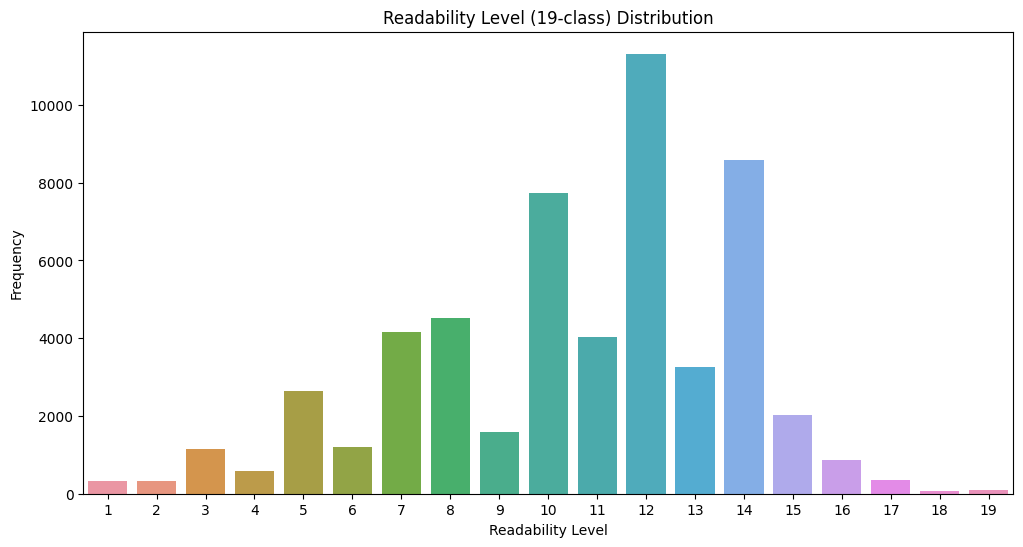

In [8]:
# Label distribution (19-level)
plt.figure(figsize=(12,6))
sns.countplot(x=df["Readability_Level_19"])
plt.title("Readability Level (19-class) Distribution")
plt.xlabel("Readability Level")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


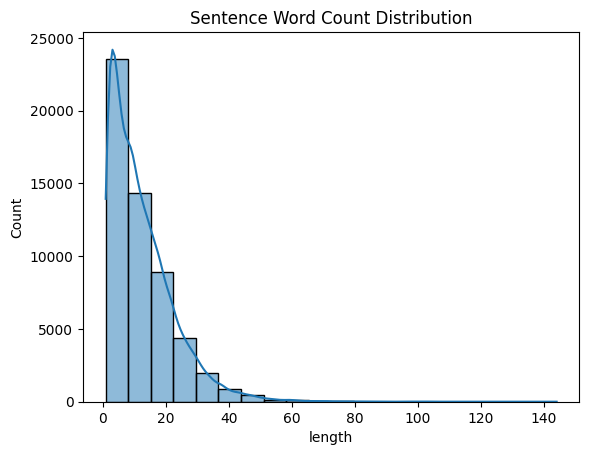

In [9]:
# Sentence length distribution
df["length"] = df["Sentence"].apply(lambda x: len(x.split()))
sns.histplot(df["length"], bins=20, kde=True)
plt.title("Sentence Word Count Distribution")
plt.show()

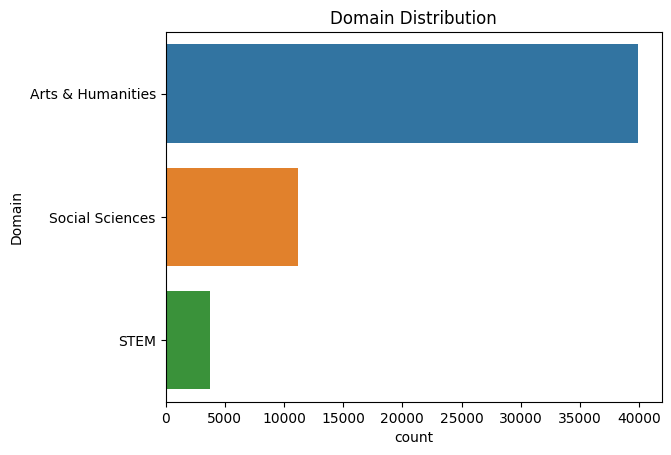

In [10]:
# Domain-wise distribution
sns.countplot(data=df, y="Domain", order=df["Domain"].value_counts().index)
plt.title("Domain Distribution")
plt.show()


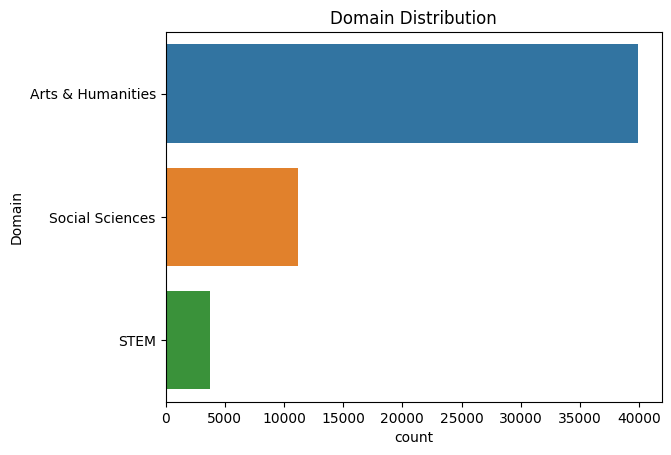

In [11]:
# Domain-wise distribution
sns.countplot(data=df, y="Domain", order=df["Domain"].value_counts().index)
plt.title("Domain Distribution")
plt.show()


# Feature Extraction ?

In [12]:
# def attach_morphological_features(example):
#     sentence = example["Sentence"]
    
#     sentence_features = morph_dict.get(sentence)
#     for feature in morph_features:
#         if sentence_features:
#             feature_values = sentence_features[feature]
#             feature_string = " ".join(feature_values)
#             example[feature] = feature_string
#         else:
#             if sentence != "":
#                 print("cant find morph features for sentence:", sentence)
#             example[feature] = ""
#     return example

# with open("/kaggle/input/outputs-dep/morph_features_dict_train.json", "r") as f:
#     morph_dict_train = json.load(f)

# with open("/kaggle/input/outputs-dep/morph_features_dict_validation.json", "r") as f:
#     morph_dict_eval = json.load(f)

# with open("/kaggle/input/outputs-dep/morph_features_dict_test.json", "r") as f:
#     morph_dict_test = json.load(f)

# # merge dicts
# morph_dict = {**morph_dict_train, **morph_dict_eval, **morph_dict_test}

# # Define the morph features resulted from dep graph you want
# # morph_features = ["prc3", "prc2", "prc1", "prc0", "enc0", "gen", "num", "cas", "per", "asp", "vox", "mod", "stt", "rat", "token_type"]
# morph_features = ["gen", "num", "cas", "per", "asp", "vox", "mod", "stt", "rat", "token_type"]

# # Attach pos tags for all sentences and remove those who dont have
# print("Attach morph features for dataset")
# dataset = dataset.map(attach_morphological_features)

# print("Attach morph features for eval_dataset")
# eval_dataset = eval_dataset.map(attach_morphological_features)

# print("Attach morph features for test_dataset")
# test_dataset = test_dataset.map(attach_morphological_features)

In [13]:
# def build_vocab_for_sequence_feature(dataset, feature_name, add_pad_token=True):
#     unique_tokens = set()
#     for example in dataset:
#         tokens = example.get(feature_name)
#         if tokens:
#             unique_tokens.update(tokens.split())
#     sorted_tokens = sorted(unique_tokens)
    
#     vocab = {}
#     start_idx = 0
#     if add_pad_token:
#         vocab['PAD'] = start_idx
#         start_idx += 1
    
#     for idx, token in enumerate(sorted_tokens, start=start_idx):
#         vocab[token] = idx
    
#     return vocab

# def build_vocab_for_all_features(dataset, feature_names):
#     feature_vocabs = {}
#     for feat in feature_names:
#         vocab = build_vocab_for_sequence_feature(dataset, feat)
#         feature_vocabs[feat] = vocab
#     return feature_vocabs

# feature_vocabs = build_vocab_for_all_features(dataset, morph_features)

# # Optional: print vocab sizes
# for feat, vocab in feature_vocabs.items():
#     print(f"{feat}: {len(vocab)} unique values")

# # Save vocabs
# import json
# with open("all_feature_vocabs.json", "w", encoding="utf-8") as f:
#     json.dump(feature_vocabs, f, ensure_ascii=False, indent=2)


# # Load all vocabs later
# with open("/kaggle/input/outputs-dep/all_feature_vocabs.json", "r", encoding="utf-8") as f:
#     feature_vocabs = json.load(f)


# # # Optional: print vocab sizes
# for feat, vocab in feature_vocabs.items():
#     print(f"{feat}: {vocab}")

In [14]:
# # try to make morph feature embedding
# def morph_str_to_ids(feature_name, morph_string):
#     return [feature_vocabs[feature_name][tag] for tag in morph_string.split()]

# # 99th percentile length for morphemes of a sentence is: 65, so will use max_len = 64
# def map_morph_str_to_ids(batch, feature_names=morph_features, max_len=64):
#     for feat in feature_names:
#         all_ids = []
#         pad_token = "PAD"
#         for morph_str in batch[feat]:
#             tags = morph_str.split()
#             # pad with "PAD" strings
#             if len(tags) > max_len:
#                 tags = tags[:max_len]
#             else:
#                 tags += [pad_token] * (max_len - len(tags))
#             ids = morph_str_to_ids(feat, " ".join(tags))
#             all_ids.append(ids)
#         batch[f"{feat}_ids"] = all_ids
#     return batch

# dataset = dataset.map(map_morph_str_to_ids, batched=True)
# eval_dataset = eval_dataset.map(map_morph_str_to_ids, batched=True)
# test_dataset = test_dataset.map(map_morph_str_to_ids, batched=True)

# morph_columns = [f"{feat}_ids" for feat in morph_features]
# # Set torch format for syntactic_feats to be correctly read by collator
# dataset.set_format("torch", columns=morph_columns, output_all_columns=True)
# eval_dataset.set_format("torch", columns=morph_columns, output_all_columns=True)
# test_dataset.set_format("torch", columns=morph_columns, output_all_columns=True)

In [15]:
# from sklearn.preprocessing import StandardScaler

# def attach_features(example, feature_dict, scaler):
#     sentence = example["Sentence"]
#     syntactic_feats = feature_dict.get(sentence)

#     if syntactic_feats is None:
#         if sentence != "":
#             print("Missing syntactic features:", sentence)
#         # replacing with mean of scaler
#         syntactic_feats = scaler.mean_
#     else:
#         syntactic_feats = scaler.transform([syntactic_feats])[0]

#     # example["syntactic_feats"] = syntactic_feats.astype(np.float32)
#     example["syntactic_feats"] = torch.tensor(syntactic_feats, dtype=torch.float32)
#     return example

# # Load CSV
# features_df_train = pd.read_csv("/kaggle/input/outputs-dep/merged_df_train.csv")
# features_df_eval = pd.read_csv("/kaggle/input/outputs-dep/merged_df_eval.csv")
# features_df_test = pd.read_csv("/kaggle/input/outputs-dep/merged_df_test.csv")

# # Load your features
# feature_columns = [col for col in features_df_train.columns if col not in ["Sentence", "labels"]]
# feature_dict_train = {row["Sentence"]: row[feature_columns].values for _, row in features_df_train.iterrows()}
# feature_dict_eval = {row["Sentence"]: row[feature_columns].values for _, row in features_df_eval.iterrows()}
# feature_dict_test = {row["Sentence"]: row[feature_columns].values for _, row in features_df_test.iterrows()}

# # Normalize only on training data
# scaler = StandardScaler()
# feature_matrix_train = np.stack(list(feature_dict_train.values()))
# scaler.fit(feature_matrix_train)

# # Create partials with the correct feature dicts
# attach_features_train = partial(attach_features, feature_dict=feature_dict_train, scaler=scaler)
# attach_features_eval = partial(attach_features, feature_dict=feature_dict_eval, scaler=scaler)
# attach_features_test = partial(attach_features, feature_dict=feature_dict_test, scaler=scaler)

# # Apply map with appropriate dict
# print("Attach features for train dataset")
# dataset = dataset.map(attach_features_train)

# print("Attach features for eval dataset")
# eval_dataset = eval_dataset.map(attach_features_eval)

# print("Attach features for test dataset")
# test_dataset = test_dataset.map(attach_features_test)

In [16]:
with open("/kaggle/input/outputs-dep/dep_graph_train.json", "r") as f:
    dep_dict_train = json.load(f)

with open("/kaggle/input/outputs-dep/dep_graph_validation.json", "r") as f:
    dep_dict_eval = json.load(f)

with open("/kaggle/input/outputs-dep/dep_graph_test.json", "r") as f:
    dep_dict_test = json.load(f)

with open("/kaggle/input/outputs-dep/dep_graph_blind_testset.json", "r") as f:
    dep_dict_blind_test = json.load(f)

def attach_dep_features(example, dep_dict):
    sentence = example["Sentence"]
    dep_graph = dep_dict.get(sentence, None)
    if dep_graph == None:
        print("cant find dep graph for sentence:", example["Sentence"])
    example["dep_graph"] = dep_graph
    return example


# Create partials with the correct feature dicts
attach_dep_train = partial(attach_dep_features, dep_dict=dep_dict_train)
attach_dep_eval = partial(attach_dep_features, dep_dict=dep_dict_eval)
attach_dep_test = partial(attach_dep_features, dep_dict=dep_dict_test)
attach_dep_blind_test = partial(attach_dep_features, dep_dict=dep_dict_blind_test)

# Apply map with appropriate dict
print("Attach dep for train dataset")
dataset = dataset.map(attach_dep_train)

print("Attach dep for eval dataset")
eval_dataset = eval_dataset.map(attach_dep_eval)

print("Attach dep for test dataset")
test_dataset = test_dataset.map(attach_dep_test)

print("Attach dep for blind test dataset")
blind_test_dataset = blind_test_dataset.map(attach_dep_blind_test)


Attach dep for train dataset
Attach dep for eval dataset
Attach dep for test dataset
Attach dep for blind test dataset


# GraphNN Try ? 

In [17]:
def add_space_after_punctuation_if_not(example):
    sentence = example["Sentence"]
    map_english_punctuation = {
        ";": ["؛"],  # Arabic semicolon
        ",": ["،", "٫"],  # Arabic comma
        "?": ["؟"],  # Arabic question mark
        "%": ["٪"],  # Arabic percentage sign
        "*": ["۝"],  # Arabic symbol for verse end
    }
    
    # count all the punctuations found in sentence
    punctuations_occurences = []
    for i, letter in enumerate(sentence):
        if letter in map_english_punctuation.keys():
            punctuations_occurences.append(i)

    # Add space after the arabic punctuation marks if its directly attached to the next word
    offset = 0
    for index in punctuations_occurences:
        adjusted_index = index + offset
        if adjusted_index < len(sentence) - 1 and sentence[adjusted_index + 1] != ' ':
            sentence = sentence[:adjusted_index + 1] + ' ' + sentence[adjusted_index + 1:]
            offset += 1  # Adjust offset due to inserted space

    example["Sentence_space_after_punct"] = sentence
    return example

# Apply map with appropriate dict
print("add_space_after_punctuation_if_not for train dataset")
dataset = dataset.map(add_space_after_punctuation_if_not)

print("add_space_after_punctuation_if_not for eval dataset")
eval_dataset = eval_dataset.map(add_space_after_punctuation_if_not)

print("add_space_after_punctuation_if_not for test dataset")
test_dataset = test_dataset.map(add_space_after_punctuation_if_not)

print("add_space_after_punctuation_if_not for blind test dataset")
blind_test_dataset = blind_test_dataset.map(add_space_after_punctuation_if_not)

add_space_after_punctuation_if_not for train dataset
add_space_after_punctuation_if_not for eval dataset
add_space_after_punctuation_if_not for test dataset
add_space_after_punctuation_if_not for blind test dataset


In [18]:
def build_vocab_for_dependency_relations(dataset):
    dep_set = set()
    for example in dataset:
        dep_graph = example.get('dep_graph')
        if dep_graph is None:
            continue
        for edge in dep_graph.get('edges', []):
            dep = edge.get('dep')
            if dep:
                dep_set.add(dep)
    return {dep: idx for idx, dep in enumerate(sorted(dep_set))}

def build_vocab_for_pos_tags_in_dependency_relations(dataset):
    pos_set = set()
    for example in dataset:
        dep_graph = example.get('dep_graph')
        if dep_graph is None:
            continue
        for node in dep_graph.get('nodes', []):
            pos_tags = node.get('pos_tags', [])
            for pos in pos_tags:
                if pos:
                    pos_set.add(pos)

    sorted_tags = sorted(pos_set)
    vocab = {'PAD': 0}  # Make sure PAD is first
    for idx, tag in enumerate(sorted_tags, start=1):
        vocab[tag] = idx

    vocab['ROOT'] = len(vocab)  # Add ROOT at the end
    return vocab


# build dependency relations from training dataset
dep2id = build_vocab_for_dependency_relations(dataset)
dep_id2label = {v: k for k, v in dep2id.items()}  # invert your dep2id dict to get labels from ids

# build pos tags relations from training dataset
pos2id = build_vocab_for_pos_tags_in_dependency_relations(dataset)
id2pos = {idx: pos for pos, idx in pos2id.items()} # invert your pos2id dict to get labels from ids

dep2id, dep_id2label, pos2id, id2pos

({'---': 0,
  'IDF': 1,
  'MOD': 2,
  'OBJ': 3,
  'PRD': 4,
  'SBJ': 5,
  'TMZ': 6,
  'TPC': 7},
 {0: '---',
  1: 'IDF',
  2: 'MOD',
  3: 'OBJ',
  4: 'PRD',
  5: 'SBJ',
  6: 'TMZ',
  7: 'TPC'},
 {'PAD': 0,
  'ADJ': 1,
  'ADP': 2,
  'ADV': 3,
  'AUX': 4,
  'CCONJ': 5,
  'DET': 6,
  'INTJ': 7,
  'NOUN': 8,
  'NUM': 9,
  'PART': 10,
  'PRON': 11,
  'PROPN': 12,
  'PUNCT': 13,
  'SCONJ': 14,
  'VERB': 15,
  'X': 16,
  'ROOT': 17},
 {0: 'PAD',
  1: 'ADJ',
  2: 'ADP',
  3: 'ADV',
  4: 'AUX',
  5: 'CCONJ',
  6: 'DET',
  7: 'INTJ',
  8: 'NOUN',
  9: 'NUM',
  10: 'PART',
  11: 'PRON',
  12: 'PROPN',
  13: 'PUNCT',
  14: 'SCONJ',
  15: 'VERB',
  16: 'X',
  17: 'ROOT'})

In [19]:
def build_graph_from_example(example):
    # i use this Sentence_space_after_punct instead of Sentence here, in order to have same number of words in dep graph
    # later can do it in the cleaning and make them all "Sentence"
    sentence = example["Sentence_space_after_punct"]
    words = sentence.split()
    dep_graph = example.get("dep_graph")

    encoding = bert_tokenizer(words, is_split_into_words=True, return_tensors='pt', add_special_tokens=True)
    word_ids = encoding.word_ids()  # use before moving to device 

    # move encoding to device for faster computation
    encoding = {k: v.to(device) for k, v in encoding.items()}  # move all to device
    input_ids = encoding['input_ids'][0]
    tokens = bert_tokenizer.convert_ids_to_tokens(input_ids)

    with torch.no_grad():
        outputs = model(**encoding)
    embeddings = outputs.last_hidden_state[0]  # [seq_len, hidden_dim]

    # word_ids = encoding.word_ids()  # len = seq_len
    word_embeddings = []

    # print("\n--- Token Mapping ---")
    for i, word in enumerate(words):
        indices = [j for j, wid in enumerate(word_ids) if wid == i]
        token_pieces = [tokens[j] for j in indices]
        if indices:
            vecs = embeddings[indices]
            word_embedding = vecs.mean(dim=0)
        else:
            word_embedding = torch.zeros(embeddings.shape[-1])

        # print(f"Word: '{word}' -> Tokens: {token_pieces}")
        word_embeddings.append(word_embedding)

    # 👇 Add ROOT node embedding at the beginning
    word_embeddings = [root_embedding] + word_embeddings

    x = torch.stack(word_embeddings)  # [num_words, hidden_dim]

    # Build edge_index and edge_attr from dep_graph
    edge_index = [[], []]
    edge_attr = []

    if dep_graph:
        for edge in dep_graph["edges"]:
            src = edge["source"]
            tgt = edge["target"]
            dep = edge.get("dep", "---")
            if src <= len(words) and tgt <= len(words):
                edge_index[0].append(src)
                edge_index[1].append(tgt)
                edge_attr.append(dep2id.get(dep, 0))

    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.long)

    # Extract POS tag ids per node (including ROOT node)
    pos_tag_ids_per_node = []

    # Add dummy POS tags for ROOT node (if you want)
    pos_tag_ids_per_node.append([pos2id.get("ROOT", -1)])  # append root pos tag for the root node postag
    
    for node in dep_graph["nodes"]:
        pos_tags = node.get("pos_tags", [])
        # convert pos tags to ids, filter unknown ones
        ids = [pos2id[pos] for pos in pos_tags if pos in pos2id]
        if not ids:
            # if no known pos tag, let it empty and it will be padded later
            ids = []
        pos_tag_ids_per_node.append(ids)
    
    # I want to check that we have same number of everything in the graph 
    # if x.shape[0] != edge_index.shape[1] or edge_attr.shape[0] != edge_index.shape[1]:
    #     print("x.shape", x.shape, "edge_index.shape", edge_index.shape, "edge_attr.shape", edge_attr.shape)
    #     raise Exception("Shape inconsistency occured!")    

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos_tag_ids=pos_tag_ids_per_node, sentence=example["Sentence"], y=torch.tensor(example["labels"]), id=torch.tensor(example["ID"]))

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_dep_graph(data, dep_id2label):
    G = nx.DiGraph()

    sentence = data.sentence
    words = sentence.split()

    # Add nodes with word labels
    for i, word in enumerate(words, 1):  # nodes are 1-indexed
        G.add_node(i, label=word)

    # Add edges with dep labels
    edge_index = data.edge_index.numpy()
    edge_attr = data.edge_attr.numpy()

    for src, tgt, dep_id in zip(edge_index[0], edge_index[1], edge_attr):
        if src == 0:
            src_label = "ROOT"
        else:
            src_label = G.nodes[src]['label']

        tgt_label = G.nodes[tgt]['label']
        dep_label = dep_id2label.get(dep_id, "UNK")

        G.add_edge(src, tgt, label=dep_label)

    # Plot graph
    pos = nx.spring_layout(G)  # layout

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
            node_size=400, node_color='lightblue', font_size=10, arrowsize=20)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12)

    plt.title("Dependency Graph Visualization")
    plt.show()

In [21]:
# # Example usage
# graph_data = build_graph_from_example(dataset[0])
# print("graph_data", graph_data)
# visualize_dep_graph(graph_data, dep_id2label)

In [22]:
def build_graphs_batch(batch):
    batch_sentences = batch["Sentence_space_after_punct"]
    batch_words = [s.split() for s in batch_sentences]
    batch_size = len(batch_words)

    # Single tokenizer call
    encoding = tokenizer(
        batch_words,
        is_split_into_words=True,
        return_tensors='pt',
        add_special_tokens=True,
        padding=True,
        truncation=True,
    )

    word_ids_list = [encoding.word_ids(batch_index=i) for i in range(batch_size)]

    # Move to device
    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)
    embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]

    graph_list = []
    for i in range(batch_size):
        words = batch_words[i]
        sentence = batch["Sentence"][i]
        dep_graph = batch["dep_graph"][i]
        labels = batch["labels"][i]
        ids = batch["ID"][i]

        word_ids = word_ids_list[i]
        input_ids = encoding["input_ids"][i]
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        seq_embeddings = embeddings[i]  # [seq_len, hidden_dim]
        word_embeddings = []

        for j, word in enumerate(words):
            indices = [k for k, wid in enumerate(word_ids) if wid == j]
            if indices:
                vecs = seq_embeddings[indices]
                word_embedding = vecs.mean(dim=0)
            else:
                word_embedding = torch.zeros(seq_embeddings.shape[-1], device=device)
            word_embeddings.append(word_embedding)

        # Add ROOT embedding
        word_embeddings = [root_embedding.to(device)] + word_embeddings
        x = torch.stack(word_embeddings)

        edge_index = [[], []]
        edge_attr = []

        if dep_graph:
            for edge in dep_graph["edges"]:
                src = edge["source"]
                tgt = edge["target"]
                dep = edge.get("dep", "---")
                if src <= len(words) and tgt <= len(words):
                    edge_index[0].append(src)
                    edge_index[1].append(tgt)
                    edge_attr.append(dep2id.get(dep, 0))

        # Extract POS tag ids per node (including ROOT node)
        pos_tag_ids_per_node = []
        
        # Add dummy POS tags for ROOT node (if you want)
        pos_tag_ids_per_node.append([pos2id.get("ROOT", -1)])  # append -1 for the root node postag
        
        for node in dep_graph["nodes"]:
            pos_tags = node.get("pos_tags", [])
            # convert pos tags to ids, filter unknown ones
            ids = [pos2id[pos] for pos in pos_tags if pos in pos2id]
            if not ids:
                # if no known pos tag, let it empty and it will be padded later
                ids = []
            pos_tag_ids_per_node.append(ids)
        
        # Pad variable length lists to fixed length
        max_len = max(len(ids) for ids in pos_tag_ids_per_node)
        padded_pos_tag_ids = [
            ids + [pos2id.get("PAD", -1)] * (max_len - len(ids)) for ids in pos_tag_ids_per_node
        ]
        
        edge_index = torch.tensor(edge_index, dtype=torch.long, device=device)
        edge_attr = torch.tensor(edge_attr, dtype=torch.long, device=device)
        pos_tag_ids_per_node = torch.tensor(padded_pos_tag_ids, dtype=torch.long, device=device)  
        y = torch.tensor(labels, dtype=torch.long, device=device)
        id = torch.tensor(ids, dtype=torch.long, device=device)

        graph = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            pos_tag_ids=pos_tag_ids_per_node,
            sentence=sentence,
            y=y,
            id=id,
        )
        graph_list.append(graph)

    return graph_list

def build_graphs_batch_v2(batch):
    batch_sentences = batch["Sentence_space_after_punct"]
    batch_words = [s.split() for s in batch_sentences]
    batch_size = len(batch_words)

    graph_list = []
    for i in range(batch_size):
        words = batch_words[i]
        sentence = batch["Sentence"][i]
        dep_graph = batch["dep_graph"][i]
        labels = batch["labels"][i] if "labels" in batch else None
        sample_id = batch["ID"][i]

        edge_index = [[], []]
        edge_attr = []

        if dep_graph:
            for edge in dep_graph["edges"]:
                src = edge["source"]
                tgt = edge["target"]
                dep = edge.get("dep", "---")
                if src <= len(words) and tgt <= len(words):
                    edge_index[0].append(src)
                    edge_index[1].append(tgt)
                    edge_attr.append(dep2id.get(dep, 0))

        # Extract POS tag ids per node (including ROOT node)
        pos_tag_ids_per_node = []
        pos_tag_ids_per_node.append([pos2id.get("ROOT", -1)])  # Root POS

        for node in dep_graph["nodes"]:
            pos_tags = node.get("pos_tags", [])
            ids = [pos2id[pos] for pos in pos_tags if pos in pos2id]
            pos_tag_ids_per_node.append(ids if ids else [])

        max_len = max(len(ids) for ids in pos_tag_ids_per_node)
        padded_pos_tag_ids = [
            ids + [pos2id.get("PAD", -1)] * (max_len - len(ids)) for ids in pos_tag_ids_per_node
        ]
        
        graph = Data(
            # Do NOT include x here; model will compute it
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr, dtype=torch.long),
            pos_tag_ids=torch.tensor(padded_pos_tag_ids, dtype=torch.long),
            sentence=sentence,
            sentence_tokenized=words,  # pass to model for BERT
            # y=torch.tensor(labels, dtype=torch.long),
            id=torch.tensor(sample_id, dtype=torch.long),
            num_nodes = len(words) + 1,  # +1 for the ROOT node
        )

        # to make sure it works for blind testset too
        if labels is not None:
            graph.y = torch.tensor(labels, dtype=torch.long)
        else:
            # place holder for official blindtestset, 0 : because it must belong to 0, numclasses - 1
            graph.y = torch.tensor([0], dtype=torch.long)


        graph_list.append(graph)

    return graph_list


In [23]:
batch_size = 256
torch.cuda.empty_cache()

print("build_graph_from_example for training dataset")
graph_list_train = []
for i in range(0, len(dataset), batch_size):
    batch = dataset[i:i+batch_size]
    graph_list_train.extend(build_graphs_batch_v2(batch))
torch.save(graph_list_train, "graph_list_train.pt")

print("build_graph_from_example for eval dataset")
graph_list_eval = []
for i in range(0, len(eval_dataset), batch_size):
    batch = eval_dataset[i:i+batch_size]
    graph_list_eval.extend(build_graphs_batch_v2(batch))
torch.save(graph_list_eval, "graph_list_eval.pt")

print("build_graph_from_example for test dataset")
graph_list_test = []
for i in range(0, len(test_dataset), batch_size):
    batch = test_dataset[i:i+batch_size]
    graph_list_test.extend(build_graphs_batch_v2(batch))
torch.save(graph_list_test, "graph_list_test.pt")

print("build_graph_from_example for blind test dataset")
graph_list_blind_test = []
for i in range(0, len(blind_test_dataset), batch_size):
    batch = blind_test_dataset[i:i+batch_size]
    graph_list_blind_test.extend(build_graphs_batch_v2(batch))
torch.save(graph_list_test, "graph_list_blind_test.pt")

build_graph_from_example for training dataset
build_graph_from_example for eval dataset
build_graph_from_example for test dataset
build_graph_from_example for blind test dataset


In [24]:
# LOADING them if already existed

# import torch
# from torch_geometric.data.data import DataEdgeAttr

# # Allowlist the PyG class you need
# torch.serialization.add_safe_globals([DataEdgeAttr])

# # Then load your data with weights_only=False
# graph_list_train = torch.load("graph_list_train.pt", weights_only=False)
# graph_list_eval = torch.load("graph_list_eval.pt", weights_only=False)
# graph_list_test = torch.load("graph_list_test.pt", weights_only=False)
# graph_list_blind_test = torch.load("graph_list_blind_test.pt", weights_only=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch_geometric.nn import NNConv, GCNConv, global_mean_pool, GATv2Conv, NNConv, TransformerConv
from torch_geometric.nn.aggr import AttentionalAggregation
from torch_geometric.nn import TransformerConv, GATConv, GraphNorm
from torch.nn import MultiheadAttention
from torch.nn.utils.rnn import pad_sequence
from coral_pytorch.losses import coral_loss
from coral_pytorch.dataset import levels_from_labelbatch

class WeightedKappaLoss(nn.Module):
    # Implementing paper: Weighted kappa loss function for multi-class classification of ordinal data in deep learning
    def __init__(self, num_classes, mode='quadratic', eps=1e-10):
        super().__init__()
        self.num_classes = num_classes
        assert mode in ['linear', 'quadratic'], "Mode must be 'linear' or 'quadratic'"
        self.mode = mode
        self.eps = eps

        # Create weight matrix omega
        labels = torch.arange(num_classes, dtype=torch.float32)
        diff = labels.unsqueeze(0) - labels.unsqueeze(1)  # shape (C,C)
        if mode == 'linear':
            weights = diff.abs()
        else:
            weights = diff.pow(2)

        # Normalize weights by max to keep in [0,1]
        weights /= weights.max()

        # Register as buffer for device compatibility
        self.register_buffer('weights', weights)

    def forward(self, y_pred, y_true):
        """
        y_pred: Float tensor of shape (N, C), probabilities (softmax outputs)
        y_true: Long tensor of shape (N,), true class indices
        """

        device = y_pred.device
        N = y_pred.size(0)
        C = self.num_classes

        # One-hot encode y_true: shape (N, C)
        y_true_onehot = torch.zeros((N, C), device=device)
        y_true_onehot.scatter_(1, y_true.unsqueeze(1), 1)

        # Normalize y_pred probabilities to sum to 1 (if not already)
        y_pred = y_pred / (y_pred.sum(dim=1, keepdim=True) + self.eps)

        # Observed matrix O_{i,j} = sum over samples of predicted prob class i and true class j
        O = y_pred.T @ y_true_onehot  # shape (C, C)

        # Marginals for predictions and truth
        hist_pred = y_pred.sum(dim=0)  # shape (C,)
        hist_true = y_true_onehot.sum(dim=0)  # shape (C,)

        # Expected matrix E_{i,j} = outer product of marginals normalized by number of samples
        E = torch.outer(hist_pred, hist_true) / N  # shape (C, C)

        # Weighted sums
        weighted_O = (self.weights * O).sum()
        weighted_E = (self.weights * E).sum()

        # Weighted kappa
        kappa = 1 - (weighted_O / (weighted_E + self.eps))

        # Loss is log(1 - kappa) as per paper
        # from paper: 
        # However, optimization of the loss function (L ) is normally presented as a minimization problem, therefore in Eq. (4) we present
        # the same problem converted to minimization. Notice that in this case, we propose to take the logarithm of the index, in order to increase the penalization of incorrect assignments.
        # minimize L = log (1 − κ ) where L ∈ (−∞, log 2] (4)
        loss = torch.log(1 - kappa + self.eps)
        return loss

class ImprovedSimpleEdgeGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_relations, num_pos_tags, pos_emb_dim=63, dropout=0.1, conv_layers=3):
        super().__init__()
        self.num_classes = num_classes
        self.conv_layers = conv_layers
        self.wkl = WeightedKappaLoss(num_classes)
        self.pos_emb = nn.Embedding(num_pos_tags, pos_emb_dim)

        edge_embedding_size = hidden_dim
        self.edge_emb = nn.Embedding(num_relations, edge_embedding_size)
        # Try larger too ?
        self.edge_proj = nn.Sequential(
            nn.Linear(edge_embedding_size, edge_embedding_size),
            nn.ReLU(),
            nn.Linear(edge_embedding_size, edge_embedding_size)
        )

        input_dim_total = input_dim + pos_emb_dim
        self.node_proj = nn.Sequential(
            nn.Linear(input_dim_total, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.edge_fuse_proj = nn.Linear(2 * edge_embedding_size, hidden_dim)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.conv_layers = conv_layers
        self.dropout = nn.Dropout(dropout)
        num_heads = 4
        for _ in range(conv_layers):
            self.convs.append(TransformerConv(in_channels=hidden_dim, out_channels=hidden_dim, heads=num_heads, concat=False, edge_dim=edge_embedding_size))  # replace with your conv class
            self.norms.append(nn.LayerNorm(hidden_dim))

        self.att_pool = AttentionalAggregation(
            gate_nn=nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            )
        )

        self.fc = nn.Linear(hidden_dim, num_classes - 1)
        self.fc_wkl = nn.Linear(hidden_dim, num_classes)

    def aggregate_edge_features(self, x, edge_index, edge_features):
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
    
        # Init aggregation tensors
        src_counts = torch.zeros(x.size(0), device=x.device)
        agg_edge_feats_src = torch.zeros(x.size(0), edge_features.size(1), device=x.device)
        src_counts.index_add_(0, src_nodes, torch.ones_like(src_nodes, dtype=torch.float))
        agg_edge_feats_src.index_add_(0, src_nodes, edge_features)
    
        dst_counts = torch.zeros(x.size(0), device=x.device)
        agg_edge_feats_dst = torch.zeros(x.size(0), edge_features.size(1), device=x.device)
        dst_counts.index_add_(0, dst_nodes, torch.ones_like(dst_nodes, dtype=torch.float))
        agg_edge_feats_dst.index_add_(0, dst_nodes, edge_features)
    
        # Normalize
        src_counts = src_counts.clamp(min=1).unsqueeze(-1)
        dst_counts = dst_counts.clamp(min=1).unsqueeze(-1)
        agg_edge_feats_src = agg_edge_feats_src / src_counts
        agg_edge_feats_dst = agg_edge_feats_dst / dst_counts
    
        # Fuse
        agg_edge_feats = torch.cat([agg_edge_feats_src, agg_edge_feats_dst], dim=-1)
        agg_edge_feats = self.edge_fuse_proj(agg_edge_feats)
        return agg_edge_feats
    
        
    def forward(self, data):
        x, y = data.x, data.y
        edge_index, edge_attr, batch = data.edge_index, data.edge_attr, data.batch
        pos_tag_ids = data.pos_tag_ids  # [N, 4]
        mask = (pos_tag_ids != 0).unsqueeze(-1)  # [N, 4, 1]
        
        pos_emb = self.pos_emb(pos_tag_ids)  # [N, 4, 32]
        pos_emb = pos_emb * mask.float()     # zero out padding embeddings
        
        # Compute masked average
        sum_emb = pos_emb.sum(dim=1)  # [N, 32]
        valid_counts = mask.sum(dim=1).clamp(min=1)  # avoid division by zero → [N, 1]
        pos_features = sum_emb / valid_counts  # [N, 32]

        edge_features = self.edge_emb(edge_attr.squeeze())  # [num_edges, edge_dim]
        edge_features = self.edge_proj(edge_features)      # project to hidden_dim back
        # edge_features = F.relu(self.edge_proj(edge_features))  # project to hidden_dim back and relu
        
        x = torch.cat([x, pos_features], dim=-1) # add pos to x
        x = self.node_proj(x)
        x = F.relu(x)
        x_res = x # save x to use it in the very end 
        
        x_prev = x
        for i in range(self.conv_layers):
            x_new = self.convs[i](x_prev, edge_index, edge_features)
            x_new = self.norms[i](x_new)
            x_new = F.relu(x_new)
            x_new = self.dropout(x_new)
            
            # Residual from previous layer and edge aggregation
            x = x_prev + x_new
            x = x + self.aggregate_edge_features(x, edge_index, edge_features)
            
            x_prev = x  # update for next iteration
            
        x = x + x_res  # original input residual

                
        x_pool = self.att_pool(x, batch)

        # Improves stability before the final classifier. This layer doesn’t add trainable weights — it just normalizes.
        x_pool = F.layer_norm(x_pool, x_pool.size()[1:])
        logits = self.fc(x_pool)
        
        # coral loss
        levels = levels_from_labelbatch(y, self.num_classes).to(logits.device)
        loss = coral_loss(logits, levels)

        # wkl loss
        logits_wkl = self.fc_wkl(x_pool)
        probabilities = torch.softmax(logits_wkl, dim=1)
        wkl_loss = self.wkl(probabilities, y)
        
        loss = 0.5 * loss + 0.5 * wkl_loss

        # predict from coral head, since it provided better results in general
        return {"loss": loss, "logits": logits}


class StrongerEdgeGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_relations, num_pos_tags,
                 pos_emb_dim=63, dropout=0.1, conv_layers=4, num_heads=4):
        super().__init__()
        self.num_classes = num_classes
        self.conv_layers = conv_layers
        self.wkl = WeightedKappaLoss(num_classes)
        self.pos_emb = nn.Embedding(num_pos_tags, pos_emb_dim)

        self.edge_emb = nn.Embedding(num_relations, hidden_dim)
        self.edge_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        input_dim_total = input_dim + pos_emb_dim
        self.node_proj = nn.Sequential(
            nn.Linear(input_dim_total, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Edge gating mechanism
        self.edge_gate = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )

        self.edge_fuse_proj = nn.Linear(2 * hidden_dim, hidden_dim)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)

        for i in range(conv_layers):
            if i % 2 == 0:
                self.convs.append(TransformerConv(hidden_dim, hidden_dim, heads=num_heads, concat=False, edge_dim=hidden_dim))
            else:
                self.convs.append(GATv2Conv(hidden_dim, hidden_dim, heads=num_heads, concat=False, edge_dim=hidden_dim))    
            self.norms.append(GraphNorm(hidden_dim))

        # Multi-head attention pooling over graph nodes
        self.global_query = nn.Parameter(torch.randn(1, hidden_dim))
        self.att_pool = MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        self.fc = nn.Linear(hidden_dim, num_classes - 1)
        self.fc_wkl = nn.Linear(hidden_dim, num_classes)

    def aggregate_edge_features(self, x, edge_index, edge_features):
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        x_src = x[src_nodes]
        x_dst = x[dst_nodes]

        # Gating
        gate_input = torch.cat([x_src, x_dst, edge_features], dim=-1)
        gates = self.edge_gate(gate_input)
        gated_edge_feats = gates * edge_features

        # Aggregate
        agg_edge_feats_src = torch.zeros(x.size(0), edge_features.size(1), device=x.device)
        agg_edge_feats_src.index_add_(0, src_nodes, gated_edge_feats)

        agg_edge_feats_dst = torch.zeros(x.size(0), edge_features.size(1), device=x.device)
        agg_edge_feats_dst.index_add_(0, dst_nodes, gated_edge_feats)

        agg = (agg_edge_feats_src + agg_edge_feats_dst) / 2
        return self.edge_fuse_proj(agg)

    def forward(self, data):
        x, y = data.x, data.y
        edge_index, edge_attr, batch = data.edge_index, data.edge_attr, data.batch
        pos_tag_ids = data.pos_tag_ids

        mask = (pos_tag_ids != 0).unsqueeze(-1)
        pos_emb = self.pos_emb(pos_tag_ids) * mask.float()
        pos_features = pos_emb.sum(dim=1) / mask.sum(dim=1).clamp(min=1)

        edge_features = self.edge_proj(self.edge_emb(edge_attr.squeeze()))

        x = torch.cat([x, pos_features], dim=-1)
        x = F.relu(self.node_proj(x))
        x_res = x

        x_prev = x
        for i in range(self.conv_layers):
            if isinstance(self.convs[i], TransformerConv):
                x_new = self.convs[i](x_prev, edge_index, edge_features)
            else:
                x_new = self.convs[i](x_prev, edge_index)

            x_new = self.norms[i](x_new, batch)
            x_new = F.relu(x_new)
            x_new = self.dropout(x_new)

            x = x_prev + x_new + self.aggregate_edge_features(x_new, edge_index, edge_features)
            x_prev = x

        x = x + x_res

        # Attention pooling: batch graph → [batch_size, num_nodes, hidden_dim]        
        # Gather node embeddings per graph
        graphs = []
        for i in range(batch.max().item() + 1):
            node_indices = (batch == i).nonzero(as_tuple=True)[0]
            graphs.append(x[node_indices])
        
        # Pad graphs to same length
        padded = pad_sequence(graphs, batch_first=True)   # [B, N_max, H]
        mask = torch.ones(padded.size()[:2], dtype=torch.bool, device=x.device)
        for i, g in enumerate(graphs):
            mask[i, len(g):] = False
        
        # Attention pooling
        query = self.global_query.expand(padded.size(0), 1, -1)  # [B, 1, H]
        pooled, _ = self.att_pool(query, padded, padded, key_padding_mask=~mask)
        x_pool = pooled.squeeze(1)

        x_pool = F.layer_norm(x_pool, x_pool.size()[1:])
        logits = self.fc(x_pool)

        levels = levels_from_labelbatch(y, self.num_classes).to(logits.device)
        loss = coral_loss(logits, levels)

        logits_wkl = self.fc_wkl(x_pool)
        probabilities = torch.softmax(logits_wkl, dim=1)
        wkl_loss = self.wkl(probabilities, y)

        loss = 0.2 * loss + 0.8 * wkl_loss
        return {"loss": loss, "logits": logits}

class BERTGraphModel(nn.Module):
    def __init__(self, gnn_model, tokenizer, bert_model):
        super().__init__()
        self.gnn_model = gnn_model
        self.tokenizer = tokenizer
        self.bert_model = bert_model

    def forward(self, batch):
        # batch is a PyG Batch (collection of Data objects with sentence, etc.)
        batch_size = batch.num_graphs
        sentences = batch.sentence  # List[str], len == batch_size
        batch_words = batch.sentence_tokenized

        # Step 1: Tokenize sentences
        encoding = self.tokenizer(
            batch_words,
            is_split_into_words=True,
            return_tensors='pt',
            add_special_tokens=True,
            padding=True,
            truncation=True,
        )
        word_ids_list = [encoding.word_ids(batch_index=i) for i in range(batch_size)]

        # Move to device
        encoding = {k: v.to(device) for k, v in encoding.items()}
        
        # with torch.no_grad():
        # outputs = self.bert_model(**encoding)
        # hidden_states = outputs.last_hidden_state  # [B, seq_len, hidden]
        
        outputs = self.bert_model(**encoding, output_hidden_states=True)
        hidden_states_all = outputs.hidden_states  # tuple of (13,) [embedding + 12 hidden layers]
        
        # Example: sum last 4 layers (you can also learn weights)
        last_4_layers = hidden_states_all[-4:]  # list of tensors [B, seq_len, hidden_dim]
        hidden_states = torch.stack(last_4_layers).mean(dim=0)  # average last 4 layers
        
        # Step 2: Convert BERT embeddings to word-level x features
        x_list = []
        for i in range(batch_size):
            words = batch_words[i]
            word_ids = word_ids_list[i]
            token_embeds = hidden_states[i]
            num_words = len(batch.pos_tag_ids[i]) - 1  # exclude ROOT

            word_embeddings = []
            for j, word in enumerate(words):
                indices = [k for k, wid in enumerate(word_ids) if wid == j]
                if indices:
                    vecs = token_embeds[indices]
                    word_emb = vecs.mean(dim=0)
                else:
                    word_emb = torch.zeros(token_embeds.size(-1), device=token_embeds.device)
                word_embeddings.append(word_emb)
            
            # Use the [CLS] token embedding as root node for the sentence
            cls_emb = token_embeds[0]  # [CLS] is always at position 0 in BERT output
            word_embeddings = [cls_emb] + word_embeddings

            x_graph = torch.stack(word_embeddings, dim=0)  # [N_nodes, input_dim]
            x_list.append(x_graph)

        # Step 3: Concatenate and inject into the PyG Batch
        x_full = torch.cat(x_list, dim=0)  # [total_nodes_across_batch, input_dim]
        batch.x = x_full

        # Step 4: Pass to GNN
        return self.gnn_model(batch)

In [53]:
def pad_pos_tags(graph_list):
    max_len = max(data.pos_tag_ids.size(1) for data in graph_list)
    pad_id = pos2id.get("PAD", -1)
    for data in graph_list:
        cur_len = data.pos_tag_ids.size(1)
        if cur_len < max_len:
            padding = torch.full(
                (data.pos_tag_ids.size(0), max_len - cur_len),
                pad_id,
                dtype=data.pos_tag_ids.dtype,
                device=data.pos_tag_ids.device
            )
            data.pos_tag_ids = torch.cat([data.pos_tag_ids, padding], dim=1)
    return graph_list

graph_list_train = pad_pos_tags(graph_list_train)
graph_list_eval = pad_pos_tags(graph_list_eval)
graph_list_test = pad_pos_tags(graph_list_test)
graph_list_blind_test = pad_pos_tags(graph_list_blind_test)

In [54]:
for data in graph_list_train:
    if hasattr(data, 'edge_attr') and data.edge_attr.dim() == 1:
        data.edge_attr = data.edge_attr.unsqueeze(1)  # add feature dimension

for data in graph_list_eval:
    if hasattr(data, 'edge_attr') and data.edge_attr.dim() == 1:
        data.edge_attr = data.edge_attr.unsqueeze(1)  # add feature dimension

for data in graph_list_test:
    if hasattr(data, 'edge_attr') and data.edge_attr.dim() == 1:
        data.edge_attr = data.edge_attr.unsqueeze(1)  # add feature dimension

for data in graph_list_blind_test:
    if hasattr(data, 'edge_attr') and data.edge_attr.dim() == 1:
        data.edge_attr = data.edge_attr.unsqueeze(1)  # add feature dimension

In [55]:
from torch_geometric.loader import DataLoader

batch_size = 64
# train_loader = DataLoader(graph_list_train, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(graph_list_eval, batch_size=batch_size)
# test_loader  = DataLoader(graph_list_test, batch_size=batch_size)

# To make it faster and experiment better !!
# train_loader = DataLoader(graph_list_train[:int(len(graph_list_train))], batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(graph_list_eval[:int(len(graph_list_eval))], batch_size=batch_size)
test_loader  = DataLoader(graph_list_test[:int(len(graph_list_test))], batch_size=batch_size)
blind_test_loader  = DataLoader(graph_list_blind_test[:int(len(graph_list_blind_test))], batch_size=batch_size)

# now we will train on train,val
# validate on internal test
# final testing on the official blind test
combined_train_val = graph_list_train + graph_list_eval  # combine lists
combined_train_loader = DataLoader(combined_train_val, batch_size=batch_size, shuffle=True)

In [56]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 19  # since 1-19
bert_model_ckpt = "aubmindlab/bert-base-arabertv02"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_ckpt)
bert_model = AutoModel.from_pretrained(bert_model_ckpt).to(device)

# try 1024, with 6 layers of conv and bert 8 layers frozen ? 
# gnn_model = ImprovedSimpleEdgeGNN(input_dim=768, hidden_dim=512, num_classes=NUM_CLASSES, num_relations=len(dep2id), num_pos_tags=len(pos2id), conv_layers=16).to(device)
gnn_model = StrongerEdgeGNN(input_dim=768, hidden_dim=512, num_classes=NUM_CLASSES, num_relations=len(dep2id), num_pos_tags=len(pos2id), pos_emb_dim=32, dropout=0.1, conv_layers=16, num_heads=4).to(device)
model = BERTGraphModel(gnn_model, bert_tokenizer, bert_model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def coral_decode(logits):
    """
    logits: [batch_size, num_classes-1] tensor
    returns: numpy array of predicted class labels
    """
    probas = torch.sigmoid(logits)  # sigmoid over logits
    # For each sample, count how many thresholds are > 0.5
    preds = (probas > 0.5).sum(dim=1)
    return preds
    
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            logits = out["logits"]

            # for coral
            preds = coral_decode(logits)

            # CE decode
            # preds = logits.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return {"accuracy": acc, "qwk": qwk}

def predict(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            logits = out["logits"]
            
            # CE decode
            # preds = logits.argmax(dim=1)
            
            # coral decode
            preds = coral_decode(logits)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return all_preds, all_labels

In [57]:
# Freeze only the lower layers (first 8 of 12):
for name, param in bert_model.named_parameters():
    if name.startswith("encoder.layer.") and int(name.split(".")[2]) < 8:
        param.requires_grad = False

In [58]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

# to check if bert is also trainable 
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

Total trainable parameters: 143023973


In [ ]:
num_epochs = 10
best_acc = 0.0
best_qwk = 0.0

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for data in combined_train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)

        # For CORAL, loss is returned from model
        loss = out["loss"]

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_acc = evaluate(model, test_loader)
    val_accuracy = val_acc['accuracy']
    val_qwk = val_acc['qwk']

    # Save best accuracy model
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        torch.save(model.state_dict(), 'model_best_acc.pt')
        print(f"✅ Saved new best accuracy model: {best_acc:.4f}")

    # Save best QWK model
    if val_qwk > best_qwk:
        best_qwk = val_qwk
        torch.save(model.state_dict(), 'model_best_qwk.pt')
        print(f"✅ Saved new best QWK model: {best_qwk:.4f}")

    print(f"Epoch {epoch:02d}, Loss: {total_loss:.4f}, "
          f"Val Acc: {val_accuracy:.4f}, Val QWK: {val_qwk:.4f}")

torch.save(model.state_dict(), 'last_model.pt')

In [51]:
def output_to_file(model, loader):
    model.eval()
    all_preds, all_ids = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # dummy: set real labels all = 0
            if hasattr(data, 'y'):
                data.y = torch.zeros_like(data.y, device=data.y.device, dtype=torch.long)

            out = model(data)
            logits = out["logits"]

            # Use coral decoding or CE depending on your training
            preds = coral_decode(logits)
            preds = [int(pred) + 1 for pred in preds]
            all_preds.extend(preds)
            all_ids.extend(data.id.cpu().numpy())  # assumes sentence_id exists

    # Save to file named exactly "prediction" (no .csv)
    with open("prediction", "w") as f:
        f.write("Sentence ID,Prediction\n")
        for sid, pred in zip(all_ids, all_preds):
            f.write(f"{sid},{pred}\n")

    return all_preds, all_ids

model.load_state_dict(torch.load('model_best_qwk.pt'))
# model.load_state_dict(torch.load('model_best_acc.pt'))  # or model_best_qwk.pt
output_to_file(model, blind_test_loader)

([6,
  3,
  10,
  10,
  11,
  10,
  5,
  7,
  5,
  5,
  6,
  14,
  7,
  3,
  9,
  12,
  10,
  12,
  9,
  9,
  8,
  8,
  5,
  12,
  6,
  9,
  8,
  10,
  11,
  8,
  12,
  10,
  10,
  11,
  11,
  7,
  2,
  12,
  6,
  7,
  8,
  7,
  12,
  10,
  8,
  11,
  11,
  12,
  8,
  10,
  12,
  7,
  9,
  10,
  12,
  7,
  7,
  12,
  7,
  12,
  10,
  10,
  8,
  9,
  8,
  10,
  3,
  10,
  7,
  9,
  5,
  10,
  5,
  10,
  8,
  8,
  10,
  9,
  9,
  8,
  8,
  8,
  8,
  12,
  10,
  12,
  8,
  5,
  5,
  8,
  6,
  2,
  5,
  5,
  8,
  8,
  10,
  10,
  7,
  12,
  10,
  12,
  14,
  11,
  8,
  12,
  12,
  12,
  12,
  12,
  14,
  14,
  12,
  12,
  13,
  3,
  11,
  12,
  7,
  6,
  12,
  7,
  5,
  7,
  8,
  10,
  5,
  10,
  10,
  12,
  10,
  10,
  3,
  10,
  8,
  12,
  10,
  8,
  12,
  11,
  11,
  12,
  10,
  10,
  12,
  7,
  7,
  7,
  8,
  12,
  11,
  5,
  12,
  7,
  8,
  5,
  13,
  10,
  11,
  9,
  10,
  14,
  12,
  14,
  7,
  12,
  11,
  8,
  14,
  12,
  12,
  5,
  3,
  6,
  2,
  11,
  11,
  6,
  7,
  12,
  14,
  

# Some experiments, you dont need to continue anymore, was checking the effectiveness of syntactic, morphological features, All work here is unreported in the paper

# Tokenization

In [ ]:
def build_vocab_for_sequence_feature(dataset, feature_name):
    all_tokens = []
    for example in dataset:
        if feature_name in example and example[feature_name]:
            tokens = example[feature_name].split()
            all_tokens.extend(tokens)
    unique_tokens = sorted(set(all_tokens))
    return {token: idx for idx, token in enumerate(unique_tokens)}

def build_vocab_for_all_features(dataset, feature_names):
    feature_vocabs = {}
    for feat in feature_names:
        vocab = build_vocab_for_sequence_feature(dataset, feat)
        feature_vocabs[feat] = vocab
    return feature_vocabs


feature_vocabs = build_vocab_for_all_features(dataset, morph_features)

# Optional: print vocab sizes
for feat, vocab in feature_vocabs.items():
    print(f"{feat}: {len(vocab)} unique values")


In [ ]:
import matplotlib.pyplot as plt

feat = "Sentence"

lengths = [len(sent.split()) for sent in dataset[feat]]
max_len_sent_95 = int(np.percentile(lengths, 95))

print(f"Feature: {feat}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {sum(lengths) / len(lengths):.2f}")
print(f"95th percentile length for {feat}: {max_len_sent_95}")

plt.hist(lengths, bins=30, alpha=0.7)
plt.xlabel("Length of Sentence feature tokens")
plt.ylabel("Frequency")
plt.title(f"Length distribution for {feat}")
plt.show()


# Do the same for Morph feature 
import matplotlib.pyplot as plt

feat = morph_features[0]  # Pick one morphological feature, since all should be the same

lengths = [len(morph_str.split()) for morph_str in dataset[feat]]
max_len_morph_95 = int(np.percentile(lengths, 95))

print(f"Feature: {feat}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {sum(lengths) / len(lengths):.2f}")
print(f"95th percentile length for {feat}: {max_len_morph_95}")

plt.hist(lengths, bins=30, alpha=0.7)
plt.xlabel("Length of morphological feature tokens")
plt.ylabel("Frequency")
plt.title(f"Length distribution for {feat}")
plt.show()

In [ ]:
model_ckpt = "aubmindlab/bert-base-arabertv02"
# model_ckpt = "CAMeL-Lab/readability-arabertv02-word-CE"
# model_ckpt = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Tokenization
# def tokenize(batch):
#     return tokenizer(batch["Sentence"], batch["pos_string"], padding="max_length", truncation=True, max_length=128)

# try to make morph feature embedding
def morph_str_to_ids(feature_name, morph_string):
    return [feature_vocabs[feature_name][tag] for tag in morph_string.split()]

def tokenize(batch, feature_names=morph_features, max_len=128):
    # Tokenize the sentence
    tokenized = tokenizer(batch["Sentence"], padding="max_length", truncation=True, max_length=max_len)

    # For each morph feature, convert to ID list, pad/truncate, and store
    for feat in feature_names:
        all_ids = []
        for morph_str in batch[feat]:
            ids = morph_str_to_ids(feat, morph_str)
            if len(ids) > max_len:
                ids = ids[:max_len]
            else:
                ids = ids + [0] * (max_len - len(ids))  # pad with 0
            all_ids.append(ids)
        tokenized[f"{feat}_ids"] = all_ids

    return tokenized

encoded_dataset = dataset.map(tokenize, batched=True)
encoded_eval_dataset = eval_dataset.map(tokenize, batched=True)
encoded_test_dataset = test_dataset.map(tokenize, batched=True)

morph_columns = [f"{feat}_ids" for feat in morph_features]
torch_columns = ["input_ids", "attention_mask", "labels", "syntactic_feats"] + morph_columns

# Set torch format for syntactic_feats to be correctly read by collator
encoded_dataset.set_format("torch", columns=torch_columns, output_all_columns=True)
encoded_eval_dataset.set_format("torch", columns=torch_columns, output_all_columns=True)
encoded_test_dataset.set_format("torch", columns=torch_columns, output_all_columns=True)

# Check
type(encoded_dataset["syntactic_feats"][0]), type(encoded_dataset["input_ids"][0])

In [ ]:
print(encoded_dataset["input_ids"][0].shape)
print(type(encoded_dataset["syntactic_feats"][0]), type(encoded_dataset["input_ids"][0]), type(encoded_dataset["ud_ids"][0]))

In [ ]:
encoded_dataset[0].keys()

# Classification

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=19).to(device)

## Ordinal instead of AutoModelForSequenceClassification

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel, AutoConfig
from coral_pytorch.losses import coral_loss
from coral_pytorch.dataset import levels_from_labelbatch


class BertCoralOrdinal(BertPreTrainedModel):
    def __init__(self, config, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, num_labels - 1)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)  # shape: [batch_size, num_labels - 1]

        if labels is not None:
            # Convert labels to CORAL ordinal levels (shape: [batch_size, num_labels - 1])
            levels = levels_from_labelbatch(labels, self.num_labels).to(logits.device)
            loss = coral_loss(logits, levels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}


In [ ]:
from transformers import AutoTokenizer

num_labels = 19
config = AutoConfig.from_pretrained(model_ckpt)
model = BertCoralOrdinal.from_pretrained(model_ckpt, config=config, num_labels=num_labels)

# Try Coral With Features

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel, AutoConfig
from coral_pytorch.losses import coral_loss
from coral_pytorch.dataset import levels_from_labelbatch

class BertCoralOrdinalWithFeatures(BertPreTrainedModel):
    def __init__(self, config, num_labels, feature_dim):
        super().__init__(config)
        self.num_labels = num_labels
        self.feature_dim = feature_dim
        
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Combine BERT + syntactic features
        combined_dim = config.hidden_size + feature_dim

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, config.hidden_size),
            nn.GELU(),
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, num_labels - 1)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, syntactic_feats=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = self.dropout(outputs.pooler_output)
        
        if syntactic_feats is not None:
            # [batch_size, feature_dim]
            combined = torch.cat([pooled_output, syntactic_feats], dim=1)  # Concatenate along feature axis
        else:
            print("no syntactic_feats")
            combined = pooled_output
            
        logits = self.classifier(combined)

        if labels is not None:
            # Convert labels to CORAL ordinal levels (shape: [batch_size, num_labels - 1])
            levels = levels_from_labelbatch(labels, self.num_labels).to(logits.device)
            loss = coral_loss(logits, levels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

In [ ]:
from transformers import AutoTokenizer

num_labels = 19
config = AutoConfig.from_pretrained(model_ckpt)
model = BertCoralOrdinalWithFeatures.from_pretrained(model_ckpt, config=config, num_labels=num_labels, feature_dim=len(feature_columns))

# Try Coral Bert With Features and All Morph's embeddings 

In [ ]:
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel

class BertWithMorpholoEmbeddings(BertPreTrainedModel):
    def __init__(self, config, num_labels, morph_vocab_sizes, feature_dim, morph_emb_dim=16):
        super().__init__(config)
        self.num_labels = num_labels
        self.feature_dim = feature_dim
        self.morph_emb_dim = morph_emb_dim
        self.bert = BertModel(config)

        # Create a separate embedding layer for each morphological feature
        self.morph_embeddings = nn.ModuleDict({
            feat: nn.Embedding(vocab_size, morph_emb_dim)
            for feat, vocab_size in morph_vocab_sizes.items()
        })

        # Total morph embedding dimension = morph_emb_dim * number of morph features
        self.total_morph_dim = morph_emb_dim * len(morph_vocab_sizes)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        combined_dim = config.hidden_size + self.total_morph_dim + feature_dim

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, config.hidden_size),
            nn.GELU(),
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, num_labels - 1)
        )

        self.init_weights()

    def init_weights(self):
        # Call init_weights only if using transformers.BertPreTrainedModel's pattern
        for name, param in self.named_parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self,
                input_ids=None,
                attention_mask=None,
                syntactic_feats=None,
                labels=None,
                ud_ids=None,
                prc3_ids=None,
                prc2_ids=None,
                prc1_ids=None,
                prc0_ids=None,
                enc0_ids=None,
                gen_ids=None,
                num_ids=None,
                cas_ids=None,
                per_ids=None,
                asp_ids=None,
                vox_ids=None,
                mod_ids=None,
                stt_ids=None,
                rat_ids=None,
                token_type_ids=None):

        # Prepare a dict with all morph inputs
        morph_inputs = {
            "ud_ids": ud_ids,
            "prc3_ids": prc3_ids,
            "prc2_ids": prc2_ids,
            "prc1_ids": prc1_ids,
            "prc0_ids": prc0_ids,
            "enc0_ids": enc0_ids,
            "gen_ids": gen_ids,
            "num_ids": num_ids,
            "cas_ids": cas_ids,
            "per_ids": per_ids,
            "asp_ids": asp_ids,
            "vox_ids": vox_ids,
            "mod_ids": mod_ids,
            "stt_ids": stt_ids,
            "rat_ids": rat_ids,
            "token_type_ids": token_type_ids,
        }

        # Filter out None values (if some features are optional)
        morph_inputs = {k: v for k, v in morph_inputs.items() if v is not None}

        # Pass BERT inputs (exclude morph features)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
    
        morph_embeds = []
        for feat_name, embed_layer in self.morph_embeddings.items():
            key = feat_name + "_ids"
            if key not in morph_inputs:
                raise ValueError(f"Missing {key} in input to forward()")
            feat_ids = morph_inputs[key]
            morph_embeds.append(embed_layer(feat_ids))  # [batch, seq_len, morph_emb_dim]

        combined_feats = torch.cat(morph_embeds, dim=-1)  # [batch, seq_len, morph_emb_dim * num_feats]
    
        # Combine BERT embeddings with morph embeddings
        combined = torch.cat([token_embeddings, combined_feats], dim=-1)
    
        # Masked mean pooling
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(combined.size()).float()
        summed = torch.sum(combined * attention_mask_expanded, dim=1)
        summed_mask = torch.clamp(attention_mask_expanded.sum(1), min=1e-9)
        pooled = summed / summed_mask  # [batch_size, combined_dim]
    
        pooled = self.dropout(pooled)
    
        # Add syntactic_feats if provided
        if syntactic_feats is not None:
            combined = torch.cat([pooled, syntactic_feats], dim=1)
        else:
            combined = pooled
    
        logits = self.classifier(combined)
    
        if labels is not None:
            levels = levels_from_labelbatch(labels, self.num_labels).to(logits.device)
            loss = coral_loss(logits, levels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

In [ ]:
morph_vocab_sizes = {feat: len(vocab) for feat, vocab in feature_vocabs.items()}
feature_dim = len(feature_columns)  # e.g., if you're using handcrafted syntactic features

config = AutoConfig.from_pretrained(model_ckpt)

model = BertWithMorpholoEmbeddings.from_pretrained(
    model_ckpt,
    config=config,
    num_labels=num_labels,
    feature_dim=feature_dim,
    morph_vocab_sizes=morph_vocab_sizes,
    morph_emb_dim=16  # or any other dimension you want
)

# Try Regression

In [ ]:
class BertRegression(BertPreTrainedModel):
    def __init__(self, config, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, 1)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output).squeeze(-1)  # shape: [batch_size]

        if labels is not None:
          labels = labels.float()  # Important for regression
          loss = nn.SmoothL1Loss()(logits, labels) # SmoothL1Loss try too
          return {"loss": loss, "logits": logits}
        else:
          return {"logits": logits}


In [ ]:
from transformers import AutoTokenizer

num_labels = 19
config = AutoConfig.from_pretrained(model_ckpt)
model = BertRegression.from_pretrained(model_ckpt, config=config, num_labels=num_labels)

# Bert + syntactical Features ? 

In [ ]:
class BertWithFeaturesRegression(BertPreTrainedModel):
    def __init__(self, config, num_labels, feature_dim):
        super().__init__(config)
        self.num_labels = num_labels
        self.feature_dim = feature_dim

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Combine BERT + syntactic features
        combined_dim = config.hidden_size + feature_dim
        # print("config.hidden_size", config.hidden_size)
        # print("feature dim ", feature_dim)
        # print("combined_dim ", combined_dim)
        

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, config.hidden_size),
            nn.GELU(),
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, 1)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, syntactic_feats=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = self.dropout(outputs.pooler_output)  # [batch_size, hidden_size] = [batch_size, 768]

        if syntactic_feats is not None:
            # [batch_size, feature_dim]
            combined = torch.cat([pooled_output, syntactic_feats], dim=1)  # Concatenate along feature axis
        else:
            print("no syntactic_feats")
            combined = pooled_output

        logits = self.classifier(combined).squeeze(-1)  # [batch_size]

        if labels is not None:
            labels = labels.float()
            loss = nn.SmoothL1Loss()(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}


In [ ]:
from transformers import AutoTokenizer

num_labels = 19
config = AutoConfig.from_pretrained(model_ckpt)
model = BertWithFeaturesRegression.from_pretrained(model_ckpt, config=config, num_labels=num_labels, feature_dim=len(feature_columns))

In [ ]:
# Decode
input_ids = encoded_dataset[0]['input_ids']
sentence = tokenizer.decode(input_ids, skip_special_tokens=True)
print(sentence)


# Choose Model

In [ ]:
morph_vocab_sizes = {feat: len(vocab) for feat, vocab in feature_vocabs.items()}
feature_dim = len(feature_columns)  # e.g., if you're using handcrafted syntactic features

config = AutoConfig.from_pretrained(model_ckpt)

model = BertWithMorpholoEmbeddings.from_pretrained(
    model_ckpt,
    config=config,
    num_labels=num_labels,
    feature_dim=feature_dim,
    morph_vocab_sizes=morph_vocab_sizes,
    morph_emb_dim=16  # or any other dimension you want
)

# Custom Collator 

In [ ]:
from transformers import default_data_collator

def custom_data_collator(features):
    # Use HuggingFace's default collator to handle input_ids, attention_mask, labels, etc.
    batch = default_data_collator(features)

    # Stack syntactic features manually
    if "syntactic_feats" in features[0]:
        batch["syntactic_feats"] = torch.stack([f["syntactic_feats"] for f in features])

    # Handle morph features like ud_ids, gen_ids, etc.
    for feat in morph_features:
        key = f"{feat}_ids"
        if key in features[0]:
            batch[key] = torch.stack([f[key] for f in features])
    return batch

# Actual training

In [ ]:
training_args = TrainingArguments(
    output_dir="./barec_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    gradient_accumulation_steps=1,   # simulate bigger batch if needed
    dataloader_num_workers=4,        # speed up data loading
    fp16=True,                       # enable mixed precision for speed/memory
)


In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

def coral_decode(logits):
    """
    logits: [batch_size, num_classes-1] tensor
    returns: numpy array of predicted class labels
    """
    probas = torch.sigmoid(torch.tensor(logits))  # sigmoid over logits
    # For each sample, count how many thresholds are > 0.5
    preds = (probas > 0.5).sum(dim=1).cpu().numpy()
    return preds

def regression_decode(logits, labels):
    #  Flatten predictions and labels if needed
    logits = logits.squeeze()
    labels = labels.squeeze()

    def round_and_clip(logits, labels):
        rounded = np.round(logits).astype(int)
        return np.clip(rounded, 0, num_labels - 1)

    # Get rounded predictions for classification-based metrics
    return round_and_clip(logits, labels)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # 1. Classification
    # preds = np.argmax(logits, axis=1)
    # 2. Coral
    preds = coral_decode(logits)  # decode ordinal logits into class preds
    # 3. Regression
    # preds = regression_decode(logits, labels)

    acc = (preds == labels).mean()
    qwk = cohen_kappa_score(labels, preds, weights='quadratic')
    return {"accuracy": acc, "qwk": qwk}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # TODO:: added custom_data_collator for our new arch
    data_collator=custom_data_collator,  # 👈 use custom collator here
)


In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

# Test data

In [ ]:
def coral_predict_labels(logits: np.ndarray) -> np.ndarray:
    """
    Convert CORAL logits to predicted ordinal labels.
    The logits are shape (batch_size, num_labels - 1).
    Each logit represents the log-odds of being above a class threshold.
    """
    probs = torch.sigmoid(torch.tensor(logits))  # apply sigmoid to get probabilities
    cum_preds = probs > 0.5                      # boolean mask: passed threshold?
    labels = cum_preds.sum(dim=1).numpy()        # count how many thresholds passed
    return labels

In [ ]:
preds = trainer.predict(encoded_test_dataset)

# 1. Classification
# pred_labels = np.argmax(preds.predictions, axis=1)

# 2. Coral
pred_labels = coral_predict_labels(preds.predictions)

# 3. Regression
# raw_preds = preds.predictions.squeeze()
# pred_labels = np.clip(np.round(raw_preds), 0, num_labels - 1).astype(int)

# Add one to the label
pred_labels = pred_labels + 1

# Match format expected by evaluation script
eval_ids = [str(x) for x in encoded_test_dataset["ID"]]
submission = pd.DataFrame({
    "Sentence ID": eval_ids,
    "Prediction": pred_labels
})
submission.to_csv("Test_Sentence_Level.csv", index=False)


In [ ]:
import argparse
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error
import numpy as np

barec_7_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 4, 11: 4, 12: 5, 13: 5, 14: 6, 15: 6, 16: 7, 17: 7, 18: 7, 19: 7}
barec_5_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 3, 13: 3, 14: 4, 15: 4, 16: 5, 17: 5, 18: 5, 19: 5}
barec_3_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3}

output_path = "Test_Sentence_Level.csv"
split = "Test"
task = "Sent"
#task_split = task + "_" + split
task_name = "Sentence" if task == "Sent" else "Document"
split_name = "validation" if split == "Dev" else "test"

# Placeholder for evaluation logic
print(f"Evaluating {task_name}-level readability on {split} split using {output_path}")

# Collect predictions
pred_df = pd.read_csv(output_path, header=0)
pred_ids = [str(id) for id in list(pred_df[task_name+ " ID"])]
predictions = list(pred_df["Prediction"])

# Pair ids and predictions in a dictionary
pred_dict = dict(zip(pred_ids, predictions))

# Get the ground truth data
#data_files = {task_split: task_split+".csv"}
barec = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-"+task.lower(), split=split_name)

gold_ids = [str(id) for id in list(barec["ID"])]
labels = list(barec["Readability_Level_19"])

# Check if gold_ids and pred_ids contain exactly the same elements
if set(gold_ids) != set(pred_ids):
    raise ValueError("The output CSV file does not match the split: IDs in predictions and gold data do not align.")

# Align labels and predictions based on gold_ids order
aligned_predictions = [pred_dict[id] for id in gold_ids]
aligned_labels = labels  # already in gold_ids order

# Convert predictions and labels to int for metrics
aligned_predictions = [int(p) for p in aligned_predictions]
aligned_labels = [int(l) for l in aligned_labels]

# Accuracy
acc = accuracy_score(aligned_labels, aligned_predictions)

# Accuracy with margin of 1 level
acc_margin_1 = np.mean([abs(p - l) <= 1 for p, l in zip(aligned_predictions, aligned_labels)])

# Average absolute distance
avg_abs_dist = mean_absolute_error(aligned_labels, aligned_predictions)

# Quadratic Cohen's Kappa
qwk = cohen_kappa_score(aligned_labels, aligned_predictions, weights='quadratic')

# Accuracy for 7, 5, 3 levels
aligned_labels_7 = [barec_7_dict[l] for l in aligned_labels]
aligned_predictions_7 = [barec_7_dict[p] for p in aligned_predictions]
acc_7 = accuracy_score(aligned_labels_7, aligned_predictions_7)

aligned_labels_5 = [barec_5_dict[l] for l in aligned_labels]
aligned_predictions_5 = [barec_5_dict[p] for p in aligned_predictions]
acc_5 = accuracy_score(aligned_labels_5, aligned_predictions_5)

aligned_labels_3 = [barec_3_dict[l] for l in aligned_labels]
aligned_predictions_3 = [barec_3_dict[p] for p in aligned_predictions]
acc_3 = accuracy_score(aligned_labels_3, aligned_predictions_3)

print(f"Accuracy: {acc*100:.4f}%")
print(f"Accuracy +/-1: {acc_margin_1*100:.4f}%")
print(f"Average absolute distance: {avg_abs_dist:.6f}")
print(f"Quadratic Cohen's Kappa: {qwk*100:.4f}%")
print(f"Accuracy (7 levels): {acc_7*100:.4f}%")
print(f"Accuracy (5 levels): {acc_5*100:.4f}%")
print(f"Accuracy (3 levels): {acc_3*100:.4f}%")
print("Evaluation completed successfully.")
